# Rapid Eye Movements (REMs) detection

This notebook demonstrates how to use YASA to automatically detect rapid eye movements (REMs) on EOG data.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading

Let's load 50 seconds of EOG data (LOC and ROC) during REM sleep, sampled at 256 Hz.

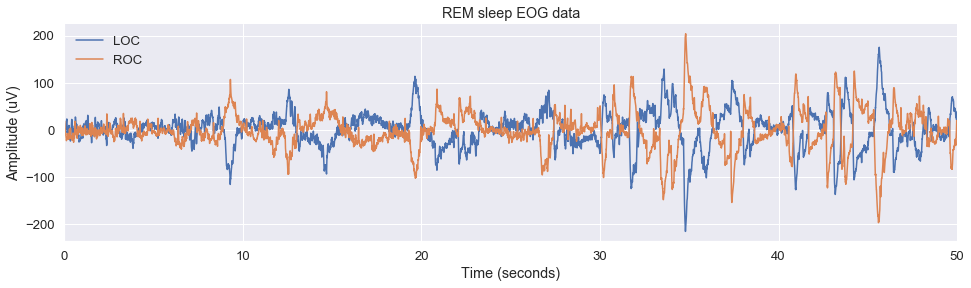

In [2]:
# Load data
file = np.load('EOGs_REM_256Hz.npz')
data, sf, chan = file['data'], file['sf'], file['chan']

# Keep only 50 seconds of data
loc = data[0, 77000:89801]
roc = data[1, 77000:89801]

# Define sampling frequency and time vector
times = np.arange(loc.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, loc, label='LOC', lw=1.5)
plt.plot(times, roc, label='ROC', lw=1.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('REM sleep EOG data')
plt.legend(loc='best', frameon=False)
sns.despine()

## Apply the detection

We use the `rem_detect` function to apply the detection. The output is a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) where each row is a unique REM and each column a property of this REM. The different input and output parameters are described in the documentation of the function.

In [12]:
from yasa import rem_detect

# Short version
# rems = rem_detect(loc, roc, sf)

# Long version (withh all optional, implicit, options)
rems = rem_detect(loc, roc, sf, hypno=None, include=4, amplitude=(50, 325), duration=(0.3, 1.5), 
                  freq_rem=(0.5, 5), downsample=True, remove_outliers=False)

print(rems.shape[0], 'REMs detected.')

rems.round(2)

20 REMs detected.


,Start,Peak,End,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope
0,8.96,9.30,9.71,0.75,88.28,67.97,268.86,158.57,242.32,150.07
1,12.36,12.55,13.00,0.64,66.15,64.11,354.94,336.08,174.50,115.95
2,19.36,19.65,20.00,0.64,85.10,75.33,298.58,248.44,214.25,228.90
3,20.67,20.86,21.44,0.77,62.04,56.47,236.22,343.66,97.10,100.57
4,27.38,27.49,27.86,0.48,63.07,60.84,711.72,487.28,210.32,136.79
5,30.08,30.22,30.69,0.61,74.35,92.87,587.11,564.31,148.31,205.78
6,30.69,30.77,31.01,0.32,43.61,72.31,563.77,799.63,216.93,263.13
7,31.64,31.77,32.32,0.68,120.87,99.85,940.80,771.89,270.14,169.56
8,32.99,33.55,33.91,0.92,89.36,98.28,135.88,195.82,236.36,253.01
9,33.91,34.08,34.62,0.70,78.92,105.76,454.07,599.80,142.28,204.52


In [4]:
# Display the documentation of the function
rem_detect?

Signature: rem_detect(loc, roc, sf, hypno=None, include=4, amplitude=(50, 325), duration=(0.3, 1.5), freq_rem=(0.5, 5), downsample=True, remove_outliers=False)
Docstring:
Rapid Eye Movements (REMs) detection.

Parameters
----------
loc, roc : array_like
    Continuous EOG data (Left and Right Ocular Canthi, LOC / ROC) channels.
    Unit must be uV.
sf : float
    Sampling frequency of the data in Hz.
hypno : array_like
    Sleep stage vector (hypnogram). If the hypnogram is loaded, the
    detection will only be applied to the value defined in
    ``include`` (default = REM sleep). ``hypno`` MUST be a 1D array of
    integers with the same size as data and where -1 = Artefact, 0 = Wake,
    1 = N1, 2 = N2, 3 = N3, 4 = REM. If you need help loading your
    hypnogram vector, please read the Visbrain documentation at
    http://visbrain.org/sleep.
include : tuple, list or int
    Values in ``hypno`` that will be included in the mask. The default is
    (4), meaning that the detection is 

### Plot the detected REMs

In [5]:
# Let's get a bool vector indicating for each sample
bool_rem = yasa.get_bool_vector(loc, sf, rems)
bool_rem

array([0, 0, 0, ..., 0, 0, 0])

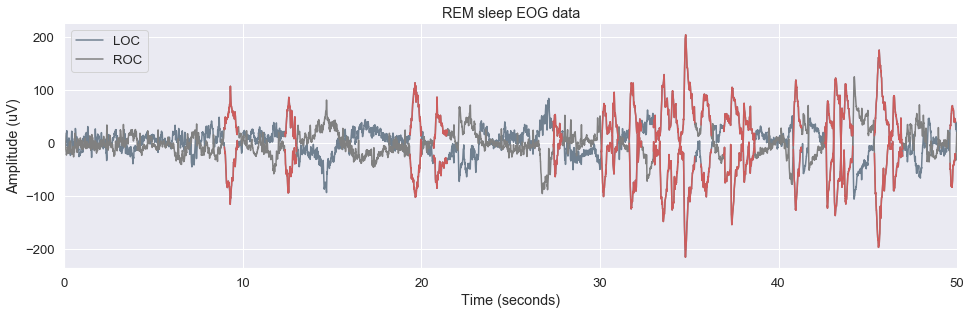

In [6]:
loc_highlight = loc * bool_rem
roc_highlight = roc * bool_rem
loc_highlight[loc_highlight == 0] = np.nan
roc_highlight[roc_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))
plt.plot(times, loc, 'slategrey', label='LOC')
plt.plot(times, roc, 'grey', label='ROC')
plt.plot(times, loc_highlight, 'indianred')
plt.plot(times, roc_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('REM sleep EOG data')
plt.legend()
sns.despine()

### Computation time

In [7]:
%timeit rem_detect(loc, roc, sf)

8.39 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
# Line profiling
# %load_ext line_profiler
# %lprun -f rem_detect rem_detect(loc, roc, sf)